# Loading Packages

In [1]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
#import tensorflow as tf
import soundfile
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
from pydub import AudioSegment
import math as mt
 
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_scorefrom, accuracy_score
import nlpaug.augmenter.audio as naa

# Data Pre-processing

In [178]:
#Emotions in the RAVDESS dataset
emotions={
  'neutral':0,
  'calm':1,
  'happy':2,
  'sad':3,
  'angry':4,
  'fearful':5,
  'disgust':6,
  'surprised':7
}

In [177]:
# Extracting features from Audio Samples
def extract_feature(y_data,sr, mfcc, chroma, mel,crossing_0):
    if chroma:
        stft=np.abs(librosa.stft(y_data))
        result=np.array([])
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=y_data, sr=sr, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    if chroma:
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result=np.hstack((result, chroma))
    if mel:
        mel=np.mean(librosa.feature.melspectrogram(y_data, sr=sr).T,axis=0)
        result=np.hstack((result, mel))
    if crossing_0:
        crossing_0= np.mean(librosa.feature.zero_crossing_rate(y_data))
        result=np.hstack((result, crossing_0))
    return result

In [176]:
#Augumenting Data with nlpaug
def augumente_data(file_path):
    data, sr = librosa.load(file_path)
    
    data_L=[]
    data_L.append(data)
    #Crop Augmenter
    aug = naa.CropAug(sampling_rate=sr)
    data_L.append(aug.augment(data))
    
    #Loudness Augmenter
    aug = naa.LoudnessAug()
    data_L.append(aug.augment(data))
    
    
    #Mask Augmenter
    aug = naa.MaskAug(sampling_rate=sr, mask_with_noise=False)
    data_L.append(aug.augment(data))
    
    #Noise
    aug = naa.NoiseAug()
    data_L.append(aug.augment(data))
    
    #Pitch_aug
    aug = naa.PitchAug(sampling_rate=sr, factor=(2,3))
    data_L.append(aug.augment(data))
    
    #Speed_Aug
    aug = naa.SpeedAug()
    data_L.append(aug.augment(data))
    
    return data_L

In [171]:
#Load the data and extract features for each sound file

def load_data():
    x,y=[],[]
    for file in glob.glob("C:\\Users\\Dragox.RS\\Documents\\GitHub\\Speech-Emotion-Recognition\Data\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
 
        _ , sr = librosa.load(file)
        for y_data in augumente_data(file):
            feature=extract_feature(y_data, sr, mfcc=True, chroma=True, mel=True,crossing_0=True)
            x.append(feature)
            y.append(emotion)
    return np.array(x),y

In [ ]:
X,y=load_data()

In [ ]:
df_x = pd.DataFrame(X)
df_y = pd.DataFrame(y)
df = pd.concat([df_x,df_y],axis=1)

In [190]:
#To encode the labels
#df["0.1"].replace(emotions,inplace=True)

In [3]:
X=df.drop(["Unnamed: 0","0.1"],axis=1)
y=df["0.1"]

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

#### Normalizing the inputs

In [14]:

# NORMALIZE DATA
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std



#### Exporting Data due it takes too much to load

In [ ]:
df.to_csv("Data_Augumented.csv")

#### Loading the Data 

In [2]:
df = pd.read_csv("Data_Augumented.csv")

# Creating a Model

## MLP Classifier

In [58]:
model_mlp=MLPClassifier(activation="relu", alpha= 0.0001, batch_size="auto", epsilon=1e-08, hidden_layer_sizes=(500, 400, 300, 200, 100), learning_rate_init= 0.0001,learning_rate='adaptive', max_iter=600)

model_mlp.fit(x_train,y_train)

In [123]:
# Predict for the test set
y_pred=model_mlp.predict(x_test)
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 79.02%


In [11]:
#GRID = [
#    {
#     'solver': ['adam'],
#     'learning_rate_init': [0.0001],
#     'max_iter': [300],
#     'hidden_layer_sizes': [(500, 400, 300, 200, 100), (400, 400, 400, 400, 400), (300, 300, 300, 300, 300), (200, 200, 200, 200, 200)],
#     'activation': ['logistic', 'tanh', 'relu'],
#     'alpha': [0.0001, 0.001, 0.005],
#     'early_stopping': [True, False]
#     }
#]
#
GRID = [
    {
     'solver': ['adam'],
     'learning_rate_init': [0.0001],
     'max_iter': [300],
     'hidden_layer_sizes': [(500, 400, 300, 200, 100)],
     'activation': ['logistic','relu'],
     'alpha': [0.0001, 0.001],
     }
]


In [12]:
model=MLPClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=GRID,
                            n_jobs=-1, cv=2, refit=True, verbose=2, 
                            return_train_score=False)

grid_search.fit(x_train, y_train)
prediction = grid_search.predict(x_test)

print(grid_search.best_params_)
print('Score of best mlp_classifier :\t{}'.format(grid_search.score(x_test, y_test)))
print(classification_report(y_test, prediction))

<IPython.core.display.Javascript object>

Fitting 2 folds for each of 4 candidates, totalling 8 fits
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (500, 400, 300, 200, 100), 'learning_rate_init': 0.0001, 'max_iter': 300, 'solver': 'adam'}
Score of best rf_classifier :	0.7872023809523809


NameError: name 'prediction_rf' is not defined

In [13]:
print('Score of best mlp_classifier :\t{}'.format(grid_search.score(x_test, y_test)))
print(classification_report(y_test, prediction))

Score of best rf_classifier :	0.7872023809523809
              precision    recall  f1-score   support

       angry       0.82      0.82      0.82       251
        calm       0.76      0.86      0.81       282
     disgust       0.82      0.80      0.81       290
     fearful       0.82      0.79      0.81       282
       happy       0.77      0.77      0.77       278
     neutral       0.72      0.66      0.69       131
         sad       0.76      0.76      0.76       249
   surprised       0.80      0.78      0.79       253

    accuracy                           0.79      2016
   macro avg       0.78      0.78      0.78      2016
weighted avg       0.79      0.79      0.79      2016



In [62]:
import pickle
# now you can save it to a file
with open('MLP_base_C.pkl', 'wb') as f:
    pickle.dump(model_mlp, f)

# and later you can load it
#with open('filename.pkl', 'rb') as f:
#    clf = pickle.load(f)

## KNeighborsClassifier - (KNN)

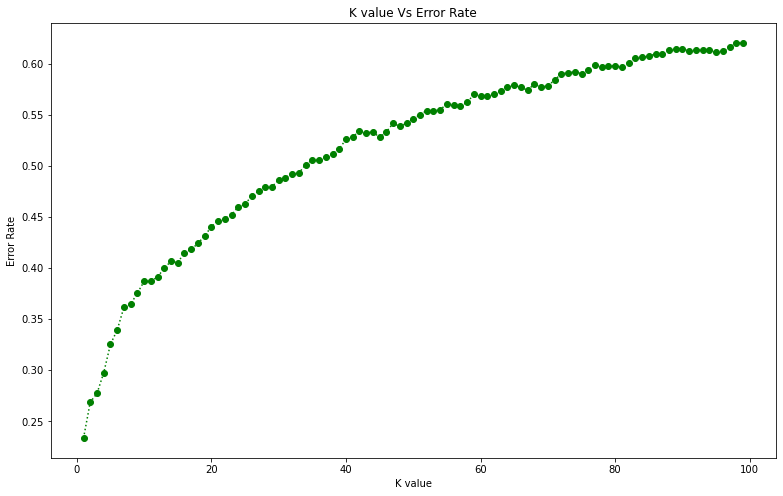

In [ ]:
error_rate=[]
for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=i)
    model = knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    error_rate.append(np.mean(pred_i != y_test))
plt.figure(figsize=(13,8))
plt.plot(range(1,100), error_rate, linestyle = 'dotted', marker = 'o',color = 'g')
plt.xlabel('K value')
plt.ylabel('Error Rate')
plt.title('K value Vs Error Rate')
plt.show() 

In [44]:
knn_model = KNeighborsClassifier()

knn_pipe = Pipeline([
        ('sc', StandardScaler()),     
        ('knn', KNeighborsClassifier()) 
    ])

knn_param = {
        'knn__n_neighbors': [1,3], # usually odd numbers
        'knn__weights': ['uniform', 'distance'],
        'knn__algorithm':['auto','ball_tree','kd_tree','brute'],
        'knn__leaf_size':np.arange(10,31,10).tolist(),
        'knn__p':[1,2]
    }

grid_knn = GridSearchCV(knn_pipe, 
                    param_grid = knn_param, 
                    n_jobs = -1, 
                    cv = 5,
                    refit = "accuracy_score",
                    verbose=2)

grid_knn.fit(x_train, y_train)

prediction_knn = grid_knn.predict(x_test)

print(grid_knn.best_params_)
print('Score of best knn_regressor :\t{}'.format(grid_knn.score(x_test, y_test)))

<IPython.core.display.Javascript object>

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'knn__algorithm': 'auto', 'knn__leaf_size': 10, 'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'}
Score of best knn_regressor :	0.7738095238095238


In [136]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1,p= 1, weights='uniform',algorithm='auto',leaf_size=15).fit(x_train,y_train)
pred = model.predict(x_test)
print(classification_report(y_test,pred))
print('Score of KNN :\t{}'.format(model.score(x_test, y_test)))

              precision    recall  f1-score   support

       angry       0.79      0.79      0.79       280
        calm       0.77      0.81      0.79       263
     disgust       0.77      0.75      0.76       264
     fearful       0.82      0.82      0.82       250
       happy       0.82      0.73      0.77       294
     neutral       0.61      0.80      0.69       124
         sad       0.77      0.70      0.73       263
   surprised       0.77      0.82      0.80       278

    accuracy                           0.77      2016
   macro avg       0.77      0.78      0.77      2016
weighted avg       0.78      0.77      0.77      2016

Score of KNN :	0.7738095238095238


## XGB Classifier

In [8]:
%time
import xgboost as xgb
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score


# create XGBoost instance with default hyper-parameters
xgb_estimator = xgb.XGBClassifier(objective='multi:softmax')


# fit the model
xgb_estimator.fit(x_train, y_train)

# evaluate on test data
print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test, xgb_estimator.predict(x_test))*100))

Wall time: 0 ns


C:\Users\Dragox.RS\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:56:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on test data: 75.2%


## AdaBoostClassifier

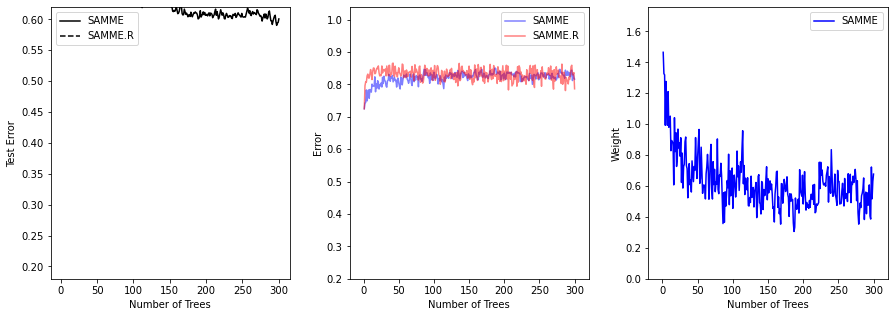

In [33]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=300, learning_rate=1
)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=300,
    learning_rate=1.5,
    algorithm="SAMME",
)

bdt_real.fit(x_train, y_train)
bdt_discrete.fit(x_train, y_train)

real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_train_predict in zip(
    bdt_real.staged_predict(x_test), bdt_discrete.staged_predict(x_test)
):
    real_test_errors.append(1.0 - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(1.0 - accuracy_score(discrete_train_predict, y_test))

n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1), discrete_test_errors, c="black", label="SAMME")
plt.plot(
    range(1, n_trees_real + 1),
    real_test_errors,
    c="black",
    linestyle="dashed",
    label="SAMME.R",
)
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel("Test Error")
plt.xlabel("Number of Trees")

plt.subplot(132)
plt.plot(
    range(1, n_trees_discrete + 1),
    discrete_estimator_errors,
    "b",
    label="SAMME",
    alpha=0.5,
)
plt.plot(
    range(1, n_trees_real + 1), real_estimator_errors, "r", label="SAMME.R", alpha=0.5
)
plt.legend()
plt.ylabel("Error")
plt.xlabel("Number of Trees")
plt.ylim((0.2, max(real_estimator_errors.max(), discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights, "b", label="SAMME")
plt.legend()
plt.ylabel("Weight")
plt.xlabel("Number of Trees")
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace=0.25)
plt.show()

# Test of a new input - Happy Testing!

In [2]:
# and later you can load it
with open('MLP_base_C.pkl', 'rb') as f:
    model = pickle.load(f)

<IPython.core.display.Javascript object>

#### Spliting the audio input to 3s segment for a better result

In [164]:
file_name='C:\\Users\\Dragox.RS\\Downloads\\Music\\243642__xtrgamr__sing-along-large-crowd-big-party.wav' #Enter your file path instead
duration = round(librosa.get_duration(filename=file_name))
for i in range(1,duration+1,3):
    t1 = i*3000+20
    t2 = (i+1)* 3000
    newAudio = AudioSegment.from_wav(file_name)
    newAudio = newAudio[t1:t2+10]
    audio_name = "Test_Sample_" + str(i)
    newAudio.export(f'Test Samples/{audio_name}.wav', format="wav")

In [165]:


import IPython.display as ipd
ipd.Audio(file_name) # load a local WAV file



#### Predicting each of the segments samples

In [166]:
Pred_L=[]
try:
    for i in range(1,duration,3):
        file_name = f"Test Samples/Test_Sample_{i}.wav"
        y_data, sr = librosa.load(file_name)
        Vector_new_input=[]
        feature=extract_feature(y_data, sr, mfcc=True, chroma=True, mel=True,crossing_0=True)
        Vector_new_input.append(feature)
        Pred_L.append(model.predict(Vector_new_input))
except Exception:
    pass

<ipython-input-4-408f46c46031>:12: FutureWarning: Pass y=[ 1.1042384e-01  1.8233442e-01  2.1041566e-01 ... -8.2798515e-08
  5.7858053e-08 -3.8406988e-08] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(y_data, sr=sr).T,axis=0)


In [167]:
def to_List(L):
    N=np.zeros_like(L)
    N=N.flatten()
    for i in range(0,len(L)):
        N[i]=L[i][0]
    return N

In [168]:
Pred_L=to_List(Pred_L)

In [169]:
def mostFrequent(arr, n):
 
    # Insert all elements in Hash.
    Hash = dict()
    for i in range(n):
        if arr[i] in Hash.keys():
            Hash[arr[i]] += 1
        else:
            Hash[arr[i]] = 1
 
    # find the max frequency
    max_count = 0
    res = -1
    for i in Hash:
        if (max_count < Hash[i]):
            res = i
            max_count = Hash[i]
         
    return res

### Final Result

In [170]:
print(mostFrequent(Pred_L, len(Pred_L)))

sad
